In [1]:
import numpy as np
import random
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, random_density_matrix
from qiskit.quantum_info.operators import Operator
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import sqrtm
from scipy.optimize import minimize

import torch
#tensorflow imports
from tensorflow import keras
from keras import layers, losses, Model
import logging
tf.get_logger().setLevel(logging.ERROR)

In [32]:
data_10 = np.load('../datasets/new_shot_levels/2q_10_.npz')
data_20 = np.load('../datasets/new_shot_levels/2q_20_.npz')
data_50 = np.load('../datasets/new_shot_levels/2q_50_.npz')
data_100 = np.load('../datasets/new_shot_levels/2q_1h_.npz')
data_1k = np.load('../datasets/new_shot_levels/2q_1k_.npz')
data_5k = np.load('../datasets/new_shot_levels/2q_5k_.npz')
data_10k = np.load('../datasets/new_shot_levels/2q_10k_.npz')

X_10 = data_10['counts']; y_10 = data_10['states']
X_20 = data_20['counts']; y_20 = data_20['states']
X_50 = data_50['counts']; y_50 = data_50['states']
X_100 = data_100['counts']; y_100 = data_100['states']
X_1k = data_1k['counts']; y_1k = data_1k['states']
X_5k = data_5k['counts']; y_5k = data_5k['states']
X_10k = data_10k['counts']; y_10k = data_10k['states']


# MLE Fidelity curves

In [ ]:
# compute Fidelity
def fidelity(rho1, rho2):
    sqrt_rho1 = sqrtm(rho1)
    F = np.trace(sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1))
    return np.real(F)**2

# Map the cholesky parameterised vector to a PSD trace 1 density matrix
def params_to_rho(params):
    # params: length 16
    L = np.zeros((4,4), dtype=complex)
    idx = 0
    # diagonal entries (real, positive)
    for i in range(4):
        L[i, i] = params[idx]
        idx += 1
    # lower-triangular off-diagonals (real + imag)
    for i in range(1, 4):
        for j in range(i):
            re = params[idx]; im = params[idx+1]
            L[i, j] = re + 1j * im
            idx += 2
    rho = L @ L.conj().T
    return rho / np.trace(rho)


def build_single_qubit_Us():
    X_cols = [np.array([1, 1])/np.sqrt(2),
              np.array([1,-1])/np.sqrt(2)]
    Y_cols = [np.array([1, 1j])/np.sqrt(2),
              np.array([1,-1j])/np.sqrt(2)] 
    Z_cols = [np.array([1,0]), np.array([0,1])]
    return {'X': np.column_stack(X_cols),
            'Y': np.column_stack(Y_cols),
            'Z': np.column_stack(Z_cols)}

def build_povm():
    proj = []
    for m in range(4):
        P = np.zeros((4,4), dtype=complex)
        P[m, m] = 1.0
        proj.append(P)

    Us = build_single_qubit_Us()
    settings = []
    for b1 in ['X','Y','Z']:
        for b2 in ['X','Y','Z']:
            settings.append(np.kron(Us[b1], Us[b2]))

    E = []
    for U in settings:
        U_dag = U.conj().T
        for P in proj:
            E.append(U @ P @ U_dag)
    return E

E_GLOBAL = build_povm()

def neg_log_likelihood(params, count):
    rho = params_to_rho(params)
    rho = 0.5*(rho + rho.conj().T)
    probs = np.array([np.trace(E @ rho).real for E in E_GLOBAL])
    probs = np.clip(probs, 0.0, None)
    s = probs.sum()
    if s <= 0: probs[:] = 1.0/len(probs)
    else: probs /= s
    return -np.sum(count * np.log(np.clip(probs, 1e-12, 1.0)))


def MLE_Avg_fidelity(data, X, y):
    shots = data['shots_per_basis']
    counts = (X * shots).astype(int)        # freq counts    

    N = X.shape[0]
    #initialise the estimator
    rho_est = np.zeros((N, 4, 4), dtype=complex)

    for i in range(N):
    
        # initial guess: uniform identity
        init = np.zeros(16)
        init[:4] = np.sqrt(1/4)
    
        res = minimize(
            neg_log_likelihood, init, args=(counts[i],),
            method='L-BFGS-B',
            options={'maxiter': 500}
        )
        #reconstruct the density matrix from cholesky decomp
        rho_est[i] = params_to_rho(res.x)

    fidelities = np.array([fidelity(rho_est[i], y[i]) for i in range(N)])

    mean_fidelity = np.mean(fidelities)
    std_fidelity  = np.std(fidelities)
    return (mean_fidelity, std_fidelity)



# NN functions

In [51]:
def alpha_to_rho(alpha):
    """Convert batch of alpha vectors to density matrices using Cholesky."""
    N = alpha.shape[0]
    rho = np.zeros((N, 4, 4), dtype=np.complex64)
    for i in range(N):
        a = alpha[i]
        L = np.zeros((4, 4), dtype=np.complex64)
        idx = 0
        for j in range(4):
            L[j, j] = a[idx]
            idx += 1
        for j in range(1, 4):
            for k in range(j):
                re = a[idx]
                im = a[idx + 1]
                L[j, k] = re + 1j * im
                idx += 2
        rho_i = L @ L.conj().T
        rho[i] = rho_i / np.trace(rho_i)
    return rho

def reconstruct_true_rho(y):
    """Convert vectorized real+imag back to complex 4x4 matrices."""
    N = y.shape[0]
    real = y[:, :16].reshape(N, 4, 4)
    imag = y[:, 16:].reshape(N, 4, 4)
    return real + 1j * imag


def rho_to_alpha(rho):
    """
    Convert a (d x d) density matrix rho into its "Cholesky parameters" alpha.
    """
    L = np.linalg.cholesky(rho + 1e-14 * np.eye(rho.shape[0]))
    d = rho.shape[0]
    alpha = []
    # diagonal (real, >0)
    for i in range(d):
        alpha.append(np.real(L[i, i]))
    # strictly lower triangle (real + imag)
    for i in range(1, d):
        for j in range(i):
            alpha.append(np.real(L[i, j]))
            alpha.append(np.imag(L[i, j]))
    return np.array(alpha, dtype=np.float32)

def fidelity(rho1, rho2):
    A = sqrtm(rho1)
    return np.real(np.trace(sqrtm(A @ rho2 @ A)))**2


def tf_sqrtm_psd(A):
    """
    Compute principal sqrt of Hermitian PSD A (batch,d,d) via eigendecomposition.
    """
    
    eigvals, eigvecs = tf.linalg.eigh(A)

    eigvals = tf.math.real(eigvals)
    eigvals = tf.clip_by_value(eigvals, 0.0, tf.reduce_max(eigvals))
    sqrtvals = tf.sqrt(eigvals)
    D = tf.cast(tf.linalg.diag(sqrtvals), tf.complex64)
    
    return eigvecs @ D @ tf.linalg.adjoint(eigvecs)

def tf_alpha_to_rho(alpha, d):
    """
    Map real alpha (batch, N_alpha) -> complex density matrices (batch, d, d).
    Enforces positivity via a softplus on the Cholesky diag.
    """
    batch = tf.shape(alpha)[0]
    # split diag vs off-diag
    raw_diag = alpha[:, :d] 
    off_vals  = alpha[:, d:] 

    # start zero L
    L = tf.zeros((batch, d, d), tf.complex64)

    diag_pos = tf.nn.softplus(raw_diag) + 1e-6 
    diag_c   = tf.cast(diag_pos, tf.complex64)
    L = tf.linalg.set_diag(L, diag_c)

    idx = 0
    for i in range(1, d):
        for j in range(i):
            re = off_vals[:, idx]
            im = off_vals[:, idx+1]
            idx += 2
            cij = (tf.cast(re, tf.complex64)
                   + 1j * tf.cast(im, tf.complex64))
            cij = tf.reshape(cij, (batch, 1, 1))

            # mask with a one-hot at (i,j)
            flat = tf.one_hot(i*d + j, d*d, dtype=tf.complex64)
            mask = tf.reshape(flat, (d, d))[None, :, :]

            L = L + cij * mask

    rho = L @ tf.linalg.adjoint(L)  
    tr  = tf.linalg.trace(rho)
    return rho / tr[:, None, None]

def make_fidelity_loss(d):
    def fidelity_loss(alpha_true, alpha_pred):
        rho_t = tf_alpha_to_rho(alpha_true, d)
        rho_p = tf_alpha_to_rho(alpha_pred, d)

        # tiny regularizer to guard numeric issues
        I = tf.eye(d, dtype=tf.complex64)[None, :, :]
        rho_t = rho_t + 1e-8 * I
        rho_p = rho_p + 1e-8 * I

        sqrt_t = tf_sqrtm_psd(rho_t)
        inter  = sqrt_t @ (rho_p @ sqrt_t)
        s_mat  = tf_sqrtm_psd(inter)

        tr_s = tf.linalg.trace(s_mat)
        F = tf.abs(tr_s)**2
        return tf.reduce_mean(1.0 - F)
    return fidelity_loss

def make_hybrid_loss(d, lam=0.8):
    """
    Hybrid loss = lam * MSE + (1 - lam) * (1 - fidelity).
    """
    fid_loss_fn = make_fidelity_loss(d)

    def hybrid_loss(alpha_true, alpha_pred):
        # MSE on the Cholesky parameters
        mse = tf.reduce_mean(tf.square(alpha_true - alpha_pred))

        # fidelity loss already = mean(1 - F)
        phys = fid_loss_fn(alpha_true, alpha_pred)

        return lam * mse + (1.0 - lam) * phys

    return hybrid_loss

def alpha_to_rho_batch(alpha):
    """Convert batch of alpha vectors to density matrices using Cholesky."""
    N = alpha.shape[0]
    rho = np.zeros((N, 4, 4), dtype=np.complex64)
    for i in range(N):
        a = alpha[i]
        L = np.zeros((4, 4), dtype=np.complex64)
        idx = 0
        for j in range(4):
            L[j, j] = a[idx]
            idx += 1
        for j in range(1, 4):
            for k in range(j):
                re = a[idx]
                im = a[idx + 1]
                L[j, k] = re + 1j * im
                idx += 2
        rho_i = L @ L.conj().T
        rho[i] = rho_i / np.trace(rho_i)
    return rho

def train_NN_fidelity(X, y, lam=0.8):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2)

    alphas = np.stack([rho_to_alpha(y[i]) for i in range(len(y))], axis=0)
    d = y_train.shape[1]

    alphas_train = np.stack([rho_to_alpha(rho) for rho in y_train], axis=0)
    N_alpha = alphas_train.shape[1]

    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(N_alpha),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=make_hybrid_loss(d, lam=lam),
    )

    # fit
    history = model.fit(
        X_train, alphas_train,
        validation_split=0.3,
        epochs=50,
        batch_size=64,
    )

    alpha_pred = model.predict(X_test)      
    rho_pred = alpha_to_rho_batch(alpha_pred)  

    # Compute fidelities
    fidelities = np.array([
        fidelity(rho_pred[i], y_test[i])
        for i in range(len(rho_pred))
    ])

    # Summary
    mean_fid = np.mean(fidelities)
    std_fid = np.std(fidelities)
    return(mean_fid, std_fid)

def train_vanilla_NN_fidelity(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2)

    alphas = np.stack([rho_to_alpha(y[i]) for i in range(len(y))], axis=0)
    d = y_train.shape[1]

    alphas_train = np.stack([rho_to_alpha(rho) for rho in y_train], axis=0)
    N_alpha = alphas_train.shape[1]

    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(N_alpha),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse"
    )

    # fit
    history = model.fit(
        X_train, alphas_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
    )

    alpha_pred = model.predict(X_test)      
    rho_pred = alpha_to_rho_batch(alpha_pred)  

    # Compute fidelities
    fidelities = np.array([
        fidelity(rho_pred[i], y_test[i])
        for i in range(len(rho_pred))
    ])

    # Summary
    mean_fid = np.mean(fidelities)
    std_fid = np.std(fidelities)
    return(mean_fid, std_fid)

In [52]:
fid_NN_10, std_NN_10 = train_vanilla_NN_fidelity(X_10, y_10)

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 843us/step - loss: 0.1815 - val_loss: 0.0244
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 0.0304 - val_loss: 0.0204
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0249 - val_loss: 0.0194
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - loss: 0.0231 - val_loss: 0.0184
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - loss: 0.0225 - val_loss: 0.0180
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 0.0221 - val_loss: 0.0179
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.0217 - val_loss: 0.0175
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - loss: 0.0215 - val_loss: 0.0171
Epoch 9/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0213 - val_loss: 0.0175
Epoch 10/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.0213 - val_loss: 0.0169
Epoch 11/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.0209 - val_loss: 0.0169
Epoch 12/50
875/875 ━━━━━━━━━━

In [53]:
fid_NN_10

0.8502760406591003

In [ ]:
fid_NN_20, std_NN_20 = train_NN_fidelity(X_20, y_20)
fid_NN_50, std_NN_50 = train_NN_fidelity(X_50, y_50)
fid_NN_100, std_NN_100 = train_NN_fidelity(X_100, y_100)
fid_NN_5k, std_NN_5k = train_NN_fidelity(X_5k, y_5k)
fid_NN_10k, std_NN_10k = train_NN_fidelity(X_10k, y_10k)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1745 - val_loss: 0.0233
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0310 - val_loss: 0.0189
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0250 - val_loss: 0.0171
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232 - val_loss: 0.0164
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0221 - val_loss: 0.0156
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215 - val_loss: 0.0155
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0210 - val_loss: 0.0150
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0209 - val_loss: 0.0150
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0206 - val_loss: 0.0147
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - val_loss: 0.0144
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - val_loss: 0.0144
Epoch 12/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [44]:
fid_NN_1k, std_NN_1k = train_NN_fidelity(X_1k, y_1k)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1734 - val_loss: 0.0140
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0242 - val_loss: 0.0095
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0173 - val_loss: 0.0079
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0071
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0062
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - val_loss: 0.0058
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0054
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0051
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0118 - val_loss: 0.0050
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0049
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0115 - val_loss: 0.0048
Epoch 12/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [54]:
fid_10, std_10 = MLE_Avg_fidelity(data_10, X_10[0:100 ,:], y_10[0:100, :])
fid_20, std_20 = MLE_Avg_fidelity(data_20, X_20[0:100 ,:], y_20[0:100, :])
fid_50, std_50 = MLE_Avg_fidelity(data_50, X_50[0:100 ,:], y_50[0:100, :])
fid_100, std_100 = MLE_Avg_fidelity(data_100, X_100[0:100 ,:], y_100[0:100, :])
fid_1k, std_1k = MLE_Avg_fidelity(data_1k, X_1k[0:100 ,:], y_1k[0:100, :])
fid_5k, std_5k = MLE_Avg_fidelity(data_5k, X_5k[0:100 ,:], y_5k[0:100, :])
fid_10k, std_10k = MLE_Avg_fidelity(data_10k, X_10k[0:100 ,:], y_10k[0:100, :])

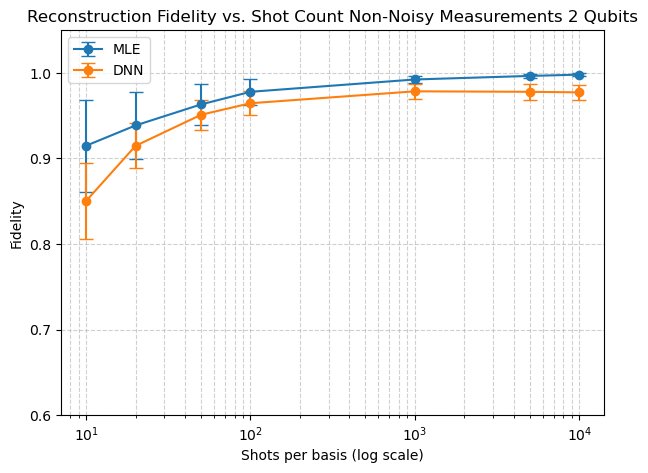

In [ ]:

shots = [10,20, 50, 100, 1000, 5000, 10000]
fidelities = [fid_10,fid_20, fid_50, fid_100, fid_1k, fid_5k, fid_10k]
std = [std_10, std_20, std_50, std_100, std_1k, std_5k, std_10k]

#NN fidelities
fidelities_NN = [fid_NN_10,fid_NN_20, fid_NN_50, fid_NN_100, fid_NN_1k, fid_NN_5k, fid_NN_10k]
std_NN =  np.array([std_NN_10, std_NN_20, std_NN_50, std_NN_100, std_NN_1k, std_NN_5k, std_NN_10k])


plt.figure(figsize=(7,5))
plt.errorbar(shots, fidelities, yerr=std, fmt='o-', capsize=5, label="MLE", markersize=6)
plt.errorbar(shots, fidelities_NN, yerr=std_NN, fmt='o-', capsize=5, label="DNN", markersize=6)

plt.xscale('log')
plt.xlabel("Shots per basis (log scale)")
plt.ylabel("Fidelity")
plt.title("Reconstruction Fidelity vs. Shot Count Non-Noisy Measurements 2 Qubits")
plt.ylim(0.6,1.05)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()